In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

---2026 BANGALURU PREDICTIONS---
Property:2BHK in Whitefield (1200 sqft)
Metro Distance: 0.5 km
Predicted Price in 2026: rupees 112.78 Lakhs
Model Accuracy (R2) : 0.9787


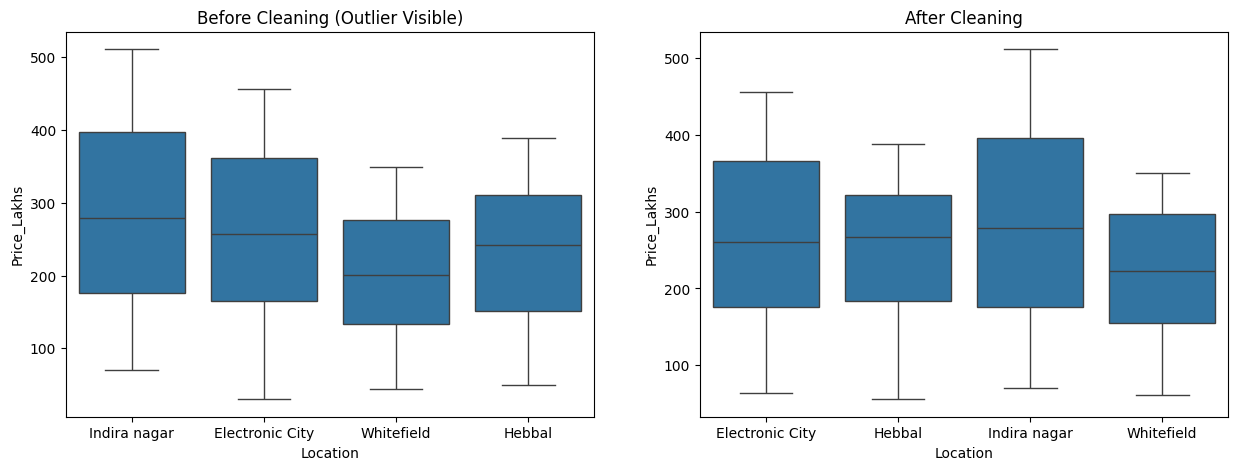

In [24]:
#Data Generation

np.random.seed(42)
n_samples = 1500

localities={
    'Indira nagar':{'rate':14500, 'type':'premium'},
    'Whitefield':{'rate':10000, 'type':'IT-Hub'},
    'Electronic City':{'rate':13000, 'type':'IT-Hub'},
    'Hebbal':{'rate':11000,'type':'Airport-Corridor'},

    #'Yelahanka':{'rate':7500,'type':'Emerging-North'}
}
data=[]
for _ in range(n_samples):
    loc=np.random.choice(list(localities.keys()))
    base_rate=localities[loc]['rate']
    area=np.random.randint(500, 3500)
    bhk = 1 if area < 900 else (2 if area<1500 else (3 if area<2400 else 4))
    data.append([loc, base_rate, area, bhk])

  #distance for Metro
    metro_dist = np.round(np.random.uniform(0.5, 10.0), 1)
    noise = np.random.normal(0, 400000)
    price = (base_rate * area) + (500000 if metro_dist < 2 else 0) + noise
    data.append([loc, area, bhk, metro_dist, round(price/100000, 2)])

df =pd.DataFrame(data, columns =["Location", "Area", "BHK", "Metro_Dist", "Price_Lakhs"])

#giving manual outliers for demonstration

df.loc[0] = ["Indira nagar", 500, 1, 0.5, 500.0] # Expensive
df.loc[1] = ["Electronic City", 4000, 4, 9.0, 30.0] # Cheap

#outlier removing

def clean_outliers(df):
  df =df[~(df.Area/df.BHK < 300)].copy()
  df_out = pd.DataFrame()
  df['PPS'] = (df.Price_Lakhs * 100000) / df.Area
  for loc, subdf in df.groupby('Location'):
    m, st = np.mean(subdf.PPS), np.std(subdf.PPS)
    reduced_df = subdf[(subdf.PPS > (m-st)) & (subdf.PPS <= (m+st))]
    df_out = pd.concat([df_out, reduced_df], ignore_index=True)
  return df_out.drop('PPS', axis = 1)

df_cleaned = clean_outliers(df)

#regression training
#location
df_encoded = pd.get_dummies(df_cleaned, columns =['Location'], drop_first = True)
X = df_encoded.drop('Price_Lakhs', axis = 1)
y = df_encoded['Price_Lakhs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
model = LinearRegression().fit(X_train, y_train)
#y_pred = model.predict(X_test)

#predict
def predict_2026(location, area, bhk, metro_dist):
  input_data = pd.DataFrame(0, index=[0], columns=X.columns)
  input_data['Area'] = area
  input_data['BHK'] = bhk
  input_data['Metro_Dist'] = metro_dist
  #if f'Location_{location}' in input_data.columns:
  #  input_data[f'Location_{location}'] = 1
  loc_col = f'Location_{location}'
  if loc_col in input_data.columns:
    input_data[loc_col] = 1

 #2025 data

  p_2025 = model.predict(input_data)[0]

  growth = 1.08 #logic for 2026 - 8% market growth + 10% metro nearness
  if metro_dist <= 1.5:

    growth += 0.10
  return round(p_2025 * growth, 2)

#outliers and clean data
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sb.boxplot(x='Location', y='Price_Lakhs', data=df, ax=ax[0]).set_title("Before Cleaning (Outlier Visible)")
sb.boxplot(x='Location', y='Price_Lakhs', data=df_cleaned, ax=ax[1]).set_title("After Cleaning")

loc_test, area_test, bhk_test, metro_dist_test = 'Whitefield', 1200, 2, 0.5
res = predict_2026(loc_test, area_test, bhk_test, metro_dist_test)

print(f"---2026 BANGALURU PREDICTIONS---")
print(f"Property:{bhk_test}BHK in {loc_test} ({area_test} sqft)")
print(f"Metro Distance: {metro_dist_test} km")

print(f"Predicted Price in 2026: rupees {res} Lakhs")
print(f"Model Accuracy (R2) : {r2_score(y_test, model.predict(X_test)):.4f}")
